In [92]:
import os
import cv2
import random
import pytorch_lightning as pl
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import glob

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torch.functional import F
from torchvision import transforms
from pytorch_lightning import loggers as pl_loggers

from torchinfo import summary

## Load Tensorboard extension

In [100]:
%load_ext tensorboard

## Data exploration

In [2]:
NUMBER_OF_SAMPLES = 3

In [3]:
def plot_images(images, titles):
    rows = 1
    columns = 2
    fig = plt.figure(figsize=(15, 15))
    
    for i, image in enumerate(images):
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.title.set_text(titles[i])
        plt.imshow(plt.imread(image))
        
    plt.show()

### Original Images

In [5]:
dir_original = "./data/CASIA2/Au/"
dir_original_ela = "./data/CASIA2/Au-ela/"

In [6]:
images_original = sorted(glob.glob(os.path.join(dir_original, "*")))
images_original_ela = sorted(glob.glob(os.path.join(dir_original_ela, "*")))

images_original_sample = images_original[:NUMBER_OF_SAMPLES]
images_original_ela_sample = images_original_ela[:NUMBER_OF_SAMPLES]

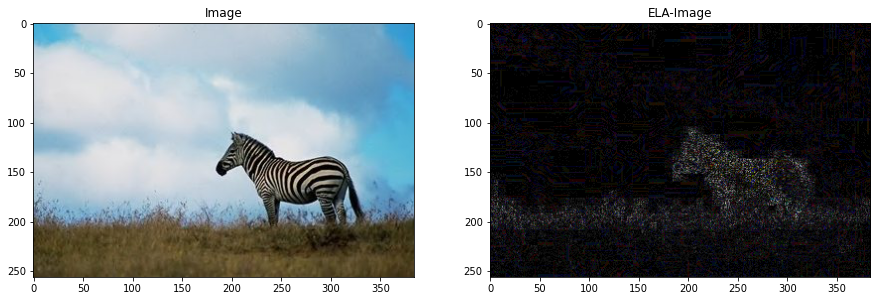

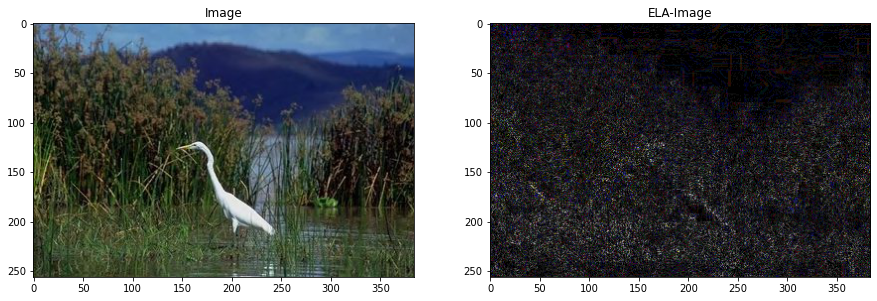

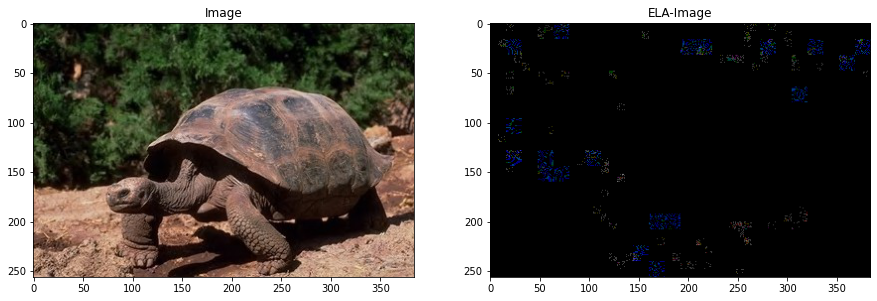

In [7]:
for i in range(NUMBER_OF_SAMPLES):
    plot_images(
         [images_original_sample[i], images_original_ela_sample[i]],
         ["Image", "ELA-Image"]
    )

### Tampered Images

In [8]:
dir_tampered = "./data/CASIA2/Tp/"
dir_tampered_ela = "./data/CASIA2/Tp-ela/"

In [9]:
images_tampered = sorted(glob.glob(os.path.join(dir_tampered, "*")))
images_tampered_ela = sorted(glob.glob(os.path.join(dir_tampered_ela, "*")))

images_tampered_sample = images_tampered[:NUMBER_OF_SAMPLES]
images_tampered_ela_sample = images_tampered_ela[:NUMBER_OF_SAMPLES]

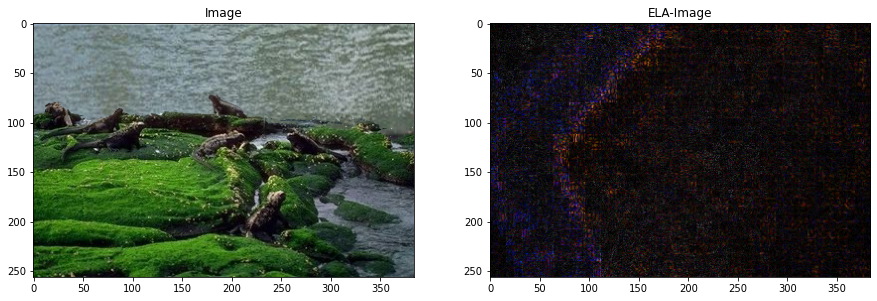

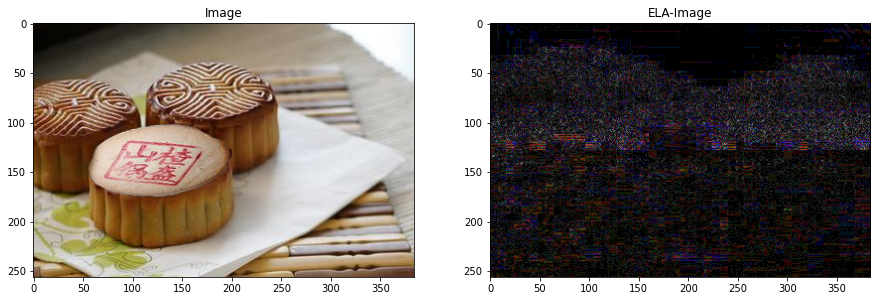

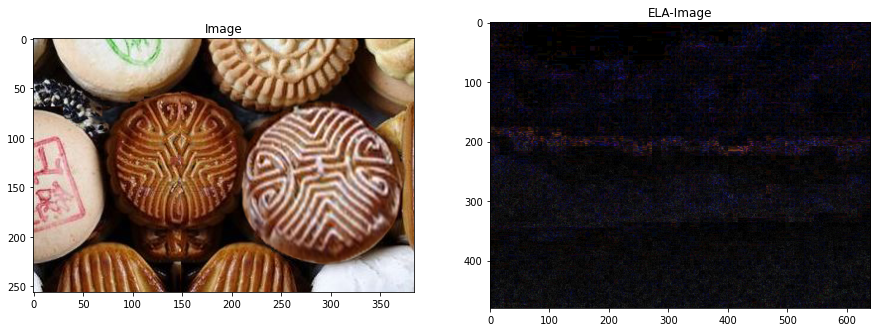

In [10]:
for i in range(NUMBER_OF_SAMPLES):
    plot_images(
         [images_tampered_sample[i], images_tampered_ela_sample[i]],
         ["Image", "ELA-Image"]
    )

### Distribution of the two classes

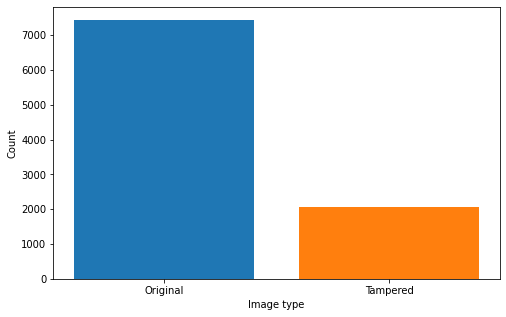

In [11]:
plt.figure(figsize=(8, 5))
plt.bar("Original", len(images_original_ela))
plt.bar("Tampered", len(images_tampered_ela))
plt.xlabel("Image type")
plt.ylabel("Count")

plt.show()

### Dataset class

In [44]:
class ForgeryDetectionDataset(Dataset):
    def __init__(self, image_paths, class_to_idx, transform=None):
        super().__init__()

        self.image_paths = image_paths
        self.transform = transform
        self.class_to_idx = class_to_idx
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = cv2.imread(image_path)
        image = cv2.resize(image, dsize=(128, 128))

        label = image_path.split("/")[3]
        label = self.class_to_idx[label]

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

### Create CNN

In [73]:
class ForgeryDetectionNetwork(pl.LightningModule):
    def __init__(self, number_of_classes, image_size):
        super().__init__()
        
        self.image_size = image_size
        self.final_size = image_size // 2

        # Conv Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # Dropout Layers
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # Dense Layers
        self.linear1 = nn.Linear(in_features=64 * 30 * 30, out_features=256)
        self.linear2 = nn.Linear(in_features=256, out_features=number_of_classes)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.dropout1(x)
        x = x.flatten(start_dim=1)
        x = F.relu(self.linear1(x))
        x = self.dropout2(x)
        x = F.sigmoid(self.linear2(x))

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        accuracy = (torch.argmax(output, dim=1) == y).sum() / len(y)

        return {
            "loss": loss,
            "accuracy": accuracy
        }

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        accuracy = (torch.argmax(output,dim=1) == y).sum() / len(y)

        return {
            "loss": loss,
            "accuracy": accuracy
        }

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        avg_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()

        self.log("Loss/train", avg_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("Accuracy/train", avg_accuracy, on_epoch=True, prog_bar=True, logger=True)

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        avg_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()

        self.log("Loss/valid", avg_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("Accuracy/valid", avg_accuracy, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())


In [74]:
summary(ForgeryDetectionNetwork(2, 128), input_size=(4, 3, 128, 128))

/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Layer (type:depth-idx)                   Output Shape              Param #
ForgeryDetectionNetwork                  --                        --
├─Conv2d: 1-1                            --                        (recursive)
├─Conv2d: 1-2                            [4, 32, 126, 126]         2,432
├─MaxPool2d: 1-3                         [4, 32, 63, 63]           --
├─Dropout: 1-4                           [4, 32, 63, 63]           --
├─Conv2d: 1-5                            [4, 64, 61, 61]           51,264
├─MaxPool2d: 1-6                         [4, 64, 30, 30]           --
├─Dropout: 1-7                           [4, 64, 30, 30]           --
├─CrossEntropyLoss: 1-8                  --                        --
├─Linear: 1-9                            [4, 256]                  14,745,856
├─Dropout: 1-10                          [4, 256]                  --
├─Linear: 1-11                           [4, 2]                    514
Total params: 14,800,066
Trainable params: 14,800,066
Non-tr

### Create dataset and dataloader

In [20]:
class_to_idx = {"Au-ela": 0, "Tp-ela": 1}
idx_to_class = {0: "Au-ela", 1: "Tp-ela"}

In [21]:
random.seed(42)

train_valid_images_paths = images_original_ela[:3000] + images_tampered_ela
random.shuffle(train_valid_images_paths)

train_image_paths, valid_image_paths = train_test_split(train_valid_images_paths, train_size=0.7)

print("Length train and validation dataset:", len(train_valid_images_paths))
print("Length train dataset", len(train_image_paths))
print("Length validation dataset", len(valid_image_paths))

Length train and validation dataset: 5064
Length train dataset 3544
Length validation dataset 1520


In [22]:
MEAN_NORMALIZE = torch.tensor([0.485, 0.456, 0.406])
STD_NORMALIZE = torch.tensor([0.229, 0.224, 0.225])

In [23]:
image_transformations = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomHorizontalFlip()
])

In [45]:
train_dataset = ForgeryDetectionDataset(train_image_paths, class_to_idx=class_to_idx, transform=image_transformations)
valid_dataset = ForgeryDetectionDataset(valid_image_paths, class_to_idx=class_to_idx, transform=image_transformations)

In [50]:
def create_dataloaders(batch_size):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    validation_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=0)

    print(f"Train dataloader shape {next(iter(train_dataloader))[0].shape}")
    print(f"Validation dataloader shape {next(iter(validation_dataloader))[0].shape}")

    return train_dataloader, validation_dataloader

In [51]:
test_train_dataloader, _ = create_dataloaders(1)

Train dataloader shape torch.Size([1, 3, 128, 128])
Validation dataloader shape torch.Size([1, 3, 128, 128])


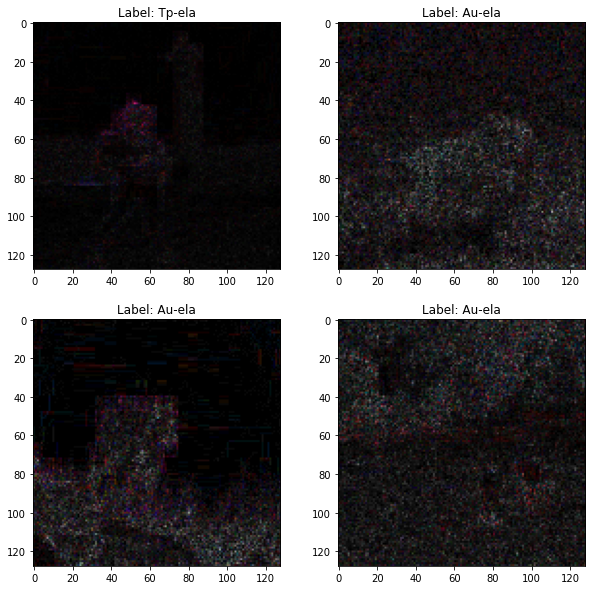

In [53]:
fig = plt.figure(figsize=(10, 10))
train_dataloader_iter = iter(test_train_dataloader)

for i in range(4):
    batch, label = next(train_dataloader_iter)

    # image = batch[0] * STD_NORMALIZE[:, None, None] + MEAN_NORMALIZE[:, None, None]
    ax = fig.add_subplot(2, 2, i + 1)
    ax.set_title(f"Label: {idx_to_class[label.item()]}")
    ax.imshow(batch[0].numpy().transpose(1, 2, 0))

plt.show()

### Create Model

In [96]:
forgery_detection_model = ForgeryDetectionNetwork(number_of_classes=len(class_to_idx), image_size=128)

In [97]:
train_dataloader, validation_dataloader = create_dataloaders(100)

Train dataloader shape torch.Size([100, 3, 128, 128])
Validation dataloader shape torch.Size([100, 3, 128, 128])


In [98]:
earlystopping_callback = pl.callbacks.EarlyStopping(monitor="Loss/valid", patience=3, min_delta=0.01)
logger = pl_loggers.TensorBoardLogger("logs/", name="Custom-Model")

In [99]:
trainer = pl.Trainer(max_epochs=30, log_every_n_steps=1, callbacks=[earlystopping_callback], logger=logger)
trainer.fit(forgery_detection_model, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Missing logger folder: logs/Custom-Model

  | Name     | Type             | Params
----------------------------------------------
0 | conv1    | Conv2d           | 2.4 K 
1 | conv2    | Conv2d           | 51.3 K
2 | maxpool  | MaxPool2d        | 0     
3 | dropout1 | Dropout          | 0     
4 | dropout2 | Dropout          | 0     
5 | linear1  | Linear           | 14.7 M
6 | linear2  | Linear           | 514   
7 | loss     | CrossEntropyLoss | 0     
----------------------------------------------
14.8 M    Trainable params
0         Non-trainable params
14.8 M    Total params
59.200    Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:05<00:05,  5.23s/it]

/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 52/52 [03:56<00:00,  4.55s/it, loss=0.43, v_num=0, Loss/valid=0.432, Accuracy/valid=0.884, Loss/train=0.425, Accuracy/train=0.888] 


In [102]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6008 (pid 65882), started 0:00:03 ago. (Use '!kill 65882' to kill it.)